# Data description: 
This dataset describes the monthly number of sales of shampoo over a 3 year period. The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright and Hyndman (1998).

# Workflow:
- Load the Time Series (TS) by Pandas Library

 # 1)  Exploration of Time Series:
- TS Line, Histogram & Probability plots
- TS Line & Box plots by intervals
- TS Lag plots
- Check the stationarity of TS, by:
     - Plotting rolling mean & standard deviation
     - Perform Dickey-Fuller test

 #  2) Seasonal ARIMA model:
- Build and evaluate the Seasonal ARIMA model: 
     - Grid-Search for the best ARIMA parameters
     - Fit the best ARIMA model
     - Evaluate model by in-sample prediction: Calculate RMSE
- Forecast the future trend: Out-of-sample prediction

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load data using Series.from_csv
from pandas import Series
#TS = Series.from_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/daily-minimum-temperatures.csv', header=0)

# Load data using pandas.read_csv
# in case, specify your own date parsing function and use the date_parser argument
from pandas import read_csv
from pandas import datetime

#def parser(x):
#    return datetime.strptime('190'+x, '%Y-%m')
TS = read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/sales-of-shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

print(TS.head())

Month
2001-01-01    266.0
2001-02-01    145.9
2001-03-01    183.1
2001-04-01    119.3
2001-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


In [3]:
#TS=pd.to_numeric(TS, errors='coerce')
TS.dropna(inplace=True)

In [4]:
TS.describe()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales of shampoo over a three year period, dtype: float64

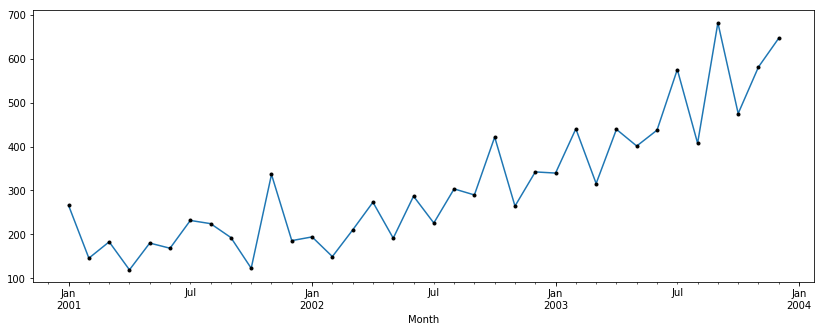

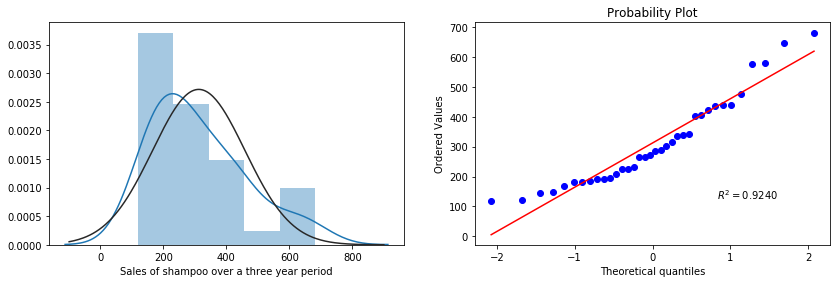

In [5]:
# Time Series Line Plot: _________________________________________
plt.figure(figsize=(14, 5))
TS.plot()
TS.plot(style="k.")
plt.show()

#Time Series Histogram and Density Plot:
fig = plt.figure(figsize=(14, 9))
ax1 = fig.add_subplot(221)
ax1=sns.distplot(TS, fit=stats.norm)
    
ax2 = fig.add_subplot(222)
res=stats.probplot(TS, plot=ax2, rvalue=True)

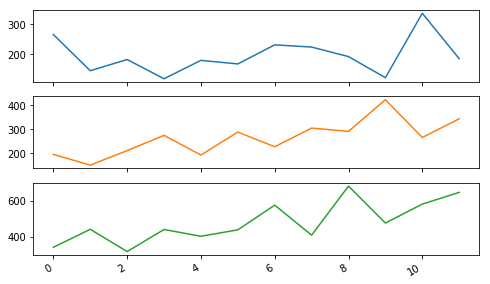

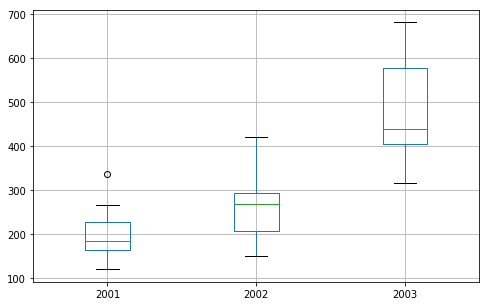

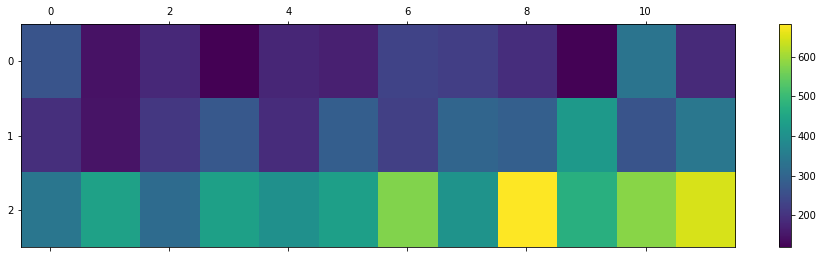

In [101]:
# Time Series Line, Box and Whisker Plots by Intervals: _________________________________________________
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper

groups = TS.groupby(TimeGrouper('Y'))
years = DataFrame()

for name, group in groups:
    years[ name.year]=group.values[0:12]
    
years.plot(subplots=True, legend=False, figsize=(8,5))
plt.show()

years.boxplot(figsize=(8,5))
plt.show()

plt.matshow(years.T, interpolation=None, aspect='auto')
plt.colorbar()
plt.show()

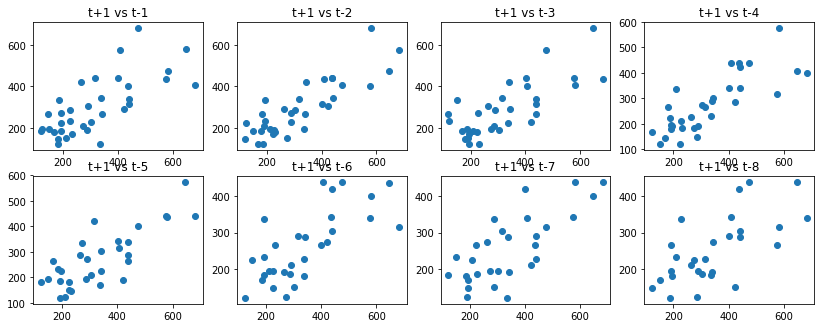

In [7]:
# Time Series Lag Scatter Plots: ____________________________________________________
from pandas import concat
from pandas.plotting import scatter_matrix

plt.figure(figsize=(14, 8))

values = DataFrame(TS.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)

for i in range(1,(lags + 1)):
    ax = plt.subplot(340 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)

plt.show()

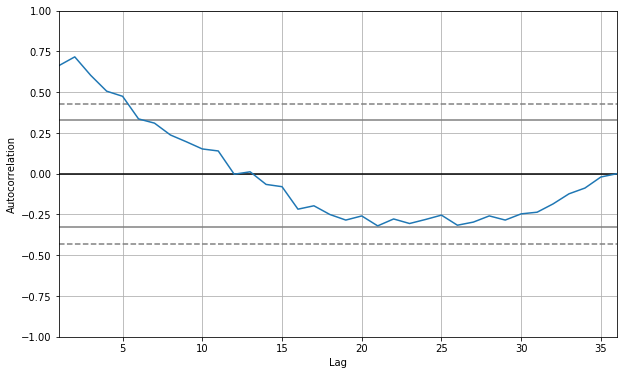

In [8]:
#Time Series Autocorrelation Plot: ________________________________________________________
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(TS)
plt.show()

In [9]:
# To check the stationarity of Time Series: _________________________________________________
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, win=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=win).mean()
    rolstd = timeseries.rolling(window=win).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

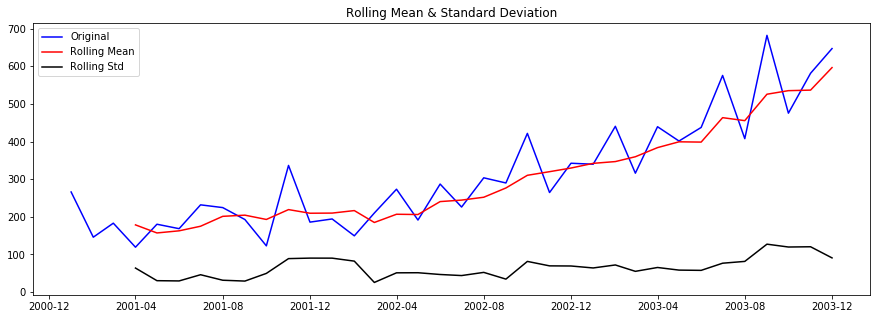

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [10]:
test_stationarity(TS, win=4)

In [5]:
import statsmodels.api as sm

In [6]:
# load passenger data set and save to DataFrame
df = pd.read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/sales-of-shampoo.csv', header=0, index_col=0, parse_dates=True, sep=',')
 
# create Series object
y = df['Sales of shampoo over a three year period']

y_train = y[:'2002-12']
y_test = y['2003':]

In [91]:
import itertools
# define the p, d and q parameters to take any value between 0 and 2

# generate all different combinations of p, d and q triplets
pdq =[(i,j,k) for i in [0, 1, 2, 4, 6] for j in range(0, 2) for k in range(0, 3)]
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i,j,k, s) for i in [0, 1, 2, 4] for j in range(0, 2) for k in range(0, 3) for s in [3, 6]]

In [92]:
# Grid-Search for the best ARIMA parameters:
import sys
import warnings
warnings.filterwarnings("ignore")
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

from sklearn.metrics import mean_squared_error
L=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            res = tmp_mdl.fit(n_jobs=-1)
            pred = res.get_prediction(start=pd.to_datetime('2001-01-01'), 
                          end=pd.to_datetime('2002-12-01'),
                          dynamic=False)          
            RMSE= np.sqrt(mean_squared_error(y_train.values, pred.predicted_mean.values))
            
            Val_pred = res.get_prediction(start=pd.to_datetime('2003-01-01'), 
                          end=pd.to_datetime('2003-12-01'),
                          dynamic=False)
            
            Val_RMSE=np.sqrt(mean_squared_error(y['2003-01-01': ].values, Val_pred.predicted_mean.values))
            
            print('RMSE= ', round(RMSE,2), ',  Val_RMSE= ', round(Val_RMSE,2), ',  (p,d,q)= ', param,', (P,D,Q)= ', param_seasonal, sep='')
            
            L.append([round(Val_RMSE, 2), round(RMSE, 2), param, param_seasonal] )
            
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
                
        except:
            continue
            
print("\n Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

RMSE= 241.09,  Val_RMSE= 491.53,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 0, 0, 3)
RMSE= 241.09,  Val_RMSE= 491.53,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 0, 0, 6)
RMSE= 175.0,  Val_RMSE= 465.25,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 0, 1, 3)
RMSE= 237.27,  Val_RMSE= 491.53,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 0, 1, 6)
RMSE= 205.63,  Val_RMSE= 478.99,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 0, 2, 3)
RMSE= 111.82,  Val_RMSE= 187.53,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 1, 0, 3)
RMSE= 121.72,  Val_RMSE= 212.74,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 1, 0, 6)
RMSE= 107.88,  Val_RMSE= 206.59,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 1, 1, 3)
RMSE= 48209826523562.45,  Val_RMSE= 16508045874.64,  (p,d,q)= (0, 0, 0), (P,D,Q)= (0, 1, 2, 3)
RMSE= 111.63,  Val_RMSE= 164.7,  (p,d,q)= (0, 0, 0), (P,D,Q)= (1, 0, 0, 3)
RMSE= 118.7,  Val_RMSE= 156.94,  (p,d,q)= (0, 0, 0), (P,D,Q)= (1, 0, 0, 6)
RMSE= 101.71,  Val_RMSE= 109.68,  (p,d,q)= (0, 0, 0), (P,D,Q)= (1, 0, 1, 3)
RMSE= 115.81,  Val_RMSE= 137.15,  (p,d,q)= (0, 0, 0), (P,D,Q)= (1, 0, 1,

RMSE= 103.17,  Val_RMSE= 174.68,  (p,d,q)= (0, 1, 0), (P,D,Q)= (1, 0, 0, 6)
RMSE= 97.98,  Val_RMSE= 187.9,  (p,d,q)= (0, 1, 0), (P,D,Q)= (1, 0, 1, 3)
RMSE= 99.18,  Val_RMSE= 243.5,  (p,d,q)= (0, 1, 0), (P,D,Q)= (1, 0, 1, 6)
RMSE= 114.24,  Val_RMSE= 196.66,  (p,d,q)= (0, 1, 0), (P,D,Q)= (1, 0, 2, 3)
RMSE= 126.13,  Val_RMSE= 113.65,  (p,d,q)= (0, 1, 0), (P,D,Q)= (1, 1, 0, 3)
RMSE= 121.68,  Val_RMSE= 129.17,  (p,d,q)= (0, 1, 0), (P,D,Q)= (1, 1, 0, 6)
RMSE= 119.36,  Val_RMSE= 118.75,  (p,d,q)= (0, 1, 0), (P,D,Q)= (1, 1, 1, 3)
RMSE= 98.01,  Val_RMSE= 188.55,  (p,d,q)= (0, 1, 0), (P,D,Q)= (2, 0, 0, 3)
RMSE= 100.18,  Val_RMSE= 237.99,  (p,d,q)= (0, 1, 0), (P,D,Q)= (2, 0, 0, 6)
RMSE= 98.55,  Val_RMSE= 178.6,  (p,d,q)= (0, 1, 0), (P,D,Q)= (2, 0, 1, 3)
RMSE= 99.92,  Val_RMSE= 294.47,  (p,d,q)= (0, 1, 0), (P,D,Q)= (2, 0, 1, 6)
RMSE= 95.94,  Val_RMSE= 252.74,  (p,d,q)= (0, 1, 0), (P,D,Q)= (2, 0, 2, 3)
RMSE= 118.32,  Val_RMSE= 98.16,  (p,d,q)= (0, 1, 0), (P,D,Q)= (2, 1, 0, 3)
RMSE= 170.6,  Val_RMSE

RMSE= 104.43,  Val_RMSE= 188.65,  (p,d,q)= (1, 0, 0), (P,D,Q)= (2, 1, 1, 3)
RMSE= 112.08,  Val_RMSE= 163.14,  (p,d,q)= (1, 0, 0), (P,D,Q)= (2, 1, 2, 3)
RMSE= 98.25,  Val_RMSE= 121.04,  (p,d,q)= (1, 0, 0), (P,D,Q)= (4, 0, 0, 3)
RMSE= 96.63,  Val_RMSE= 110.33,  (p,d,q)= (1, 0, 0), (P,D,Q)= (4, 0, 1, 3)
RMSE= 99.31,  Val_RMSE= 138.98,  (p,d,q)= (1, 0, 0), (P,D,Q)= (4, 0, 2, 3)
RMSE= 147.02,  Val_RMSE= 1346.06,  (p,d,q)= (1, 0, 0), (P,D,Q)= (4, 1, 0, 3)
RMSE= 115.42,  Val_RMSE= 64.27,  (p,d,q)= (1, 0, 0), (P,D,Q)= (4, 1, 1, 3)
RMSE= 122.27,  Val_RMSE= 91.34,  (p,d,q)= (1, 0, 0), (P,D,Q)= (4, 1, 2, 3)
RMSE= 81.68,  Val_RMSE= 102.88,  (p,d,q)= (1, 0, 1), (P,D,Q)= (0, 0, 0, 3)
RMSE= 81.68,  Val_RMSE= 102.88,  (p,d,q)= (1, 0, 1), (P,D,Q)= (0, 0, 0, 6)
RMSE= 82.89,  Val_RMSE= 111.47,  (p,d,q)= (1, 0, 1), (P,D,Q)= (0, 0, 1, 3)
RMSE= 5.358949207227427e+28,  Val_RMSE= 6.043644720682192e+50,  (p,d,q)= (1, 0, 1), (P,D,Q)= (0, 0, 1, 6)
RMSE= 87.72,  Val_RMSE= 93.64,  (p,d,q)= (1, 0, 1), (P,D,Q)= (0, 

RMSE= 4465.06,  Val_RMSE= 25901.97,  (p,d,q)= (1, 1, 1), (P,D,Q)= (0, 0, 1, 6)
RMSE= 88.19,  Val_RMSE= 177.98,  (p,d,q)= (1, 1, 1), (P,D,Q)= (0, 0, 2, 3)
RMSE= 113.46,  Val_RMSE= 118.3,  (p,d,q)= (1, 1, 1), (P,D,Q)= (0, 1, 0, 3)
RMSE= 99.33,  Val_RMSE= 123.47,  (p,d,q)= (1, 1, 1), (P,D,Q)= (0, 1, 0, 6)
RMSE= 101.39,  Val_RMSE= 130.45,  (p,d,q)= (1, 1, 1), (P,D,Q)= (0, 1, 1, 3)
RMSE= 117.1,  Val_RMSE= 139.5,  (p,d,q)= (1, 1, 1), (P,D,Q)= (0, 1, 2, 3)
RMSE= 80.98,  Val_RMSE= 198.22,  (p,d,q)= (1, 1, 1), (P,D,Q)= (1, 0, 0, 3)
RMSE= 81.08,  Val_RMSE= 192.69,  (p,d,q)= (1, 1, 1), (P,D,Q)= (1, 0, 0, 6)
RMSE= 80.18,  Val_RMSE= 195.03,  (p,d,q)= (1, 1, 1), (P,D,Q)= (1, 0, 1, 3)
RMSE= 81.13,  Val_RMSE= 206.26,  (p,d,q)= (1, 1, 1), (P,D,Q)= (1, 0, 1, 6)
RMSE= 92.19,  Val_RMSE= 210.15,  (p,d,q)= (1, 1, 1), (P,D,Q)= (1, 0, 2, 3)
RMSE= 95.72,  Val_RMSE= 101.06,  (p,d,q)= (1, 1, 1), (P,D,Q)= (1, 1, 0, 3)
RMSE= 98.42,  Val_RMSE= 116.81,  (p,d,q)= (1, 1, 1), (P,D,Q)= (1, 1, 0, 6)
RMSE= 101.15,  Val_RM

RMSE= 130.31,  Val_RMSE= 111.02,  (p,d,q)= (2, 0, 1), (P,D,Q)= (1, 0, 2, 3)
RMSE= 104.45,  Val_RMSE= 194.14,  (p,d,q)= (2, 0, 1), (P,D,Q)= (1, 1, 0, 3)
RMSE= 97.31,  Val_RMSE= 181.53,  (p,d,q)= (2, 0, 1), (P,D,Q)= (1, 1, 0, 6)
RMSE= 103.47,  Val_RMSE= 211.63,  (p,d,q)= (2, 0, 1), (P,D,Q)= (1, 1, 1, 3)
RMSE= 100.47,  Val_RMSE= 222.94,  (p,d,q)= (2, 0, 1), (P,D,Q)= (1, 1, 2, 3)
RMSE= 92.83,  Val_RMSE= 95.37,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 0, 0, 3)
RMSE= 88.83,  Val_RMSE= 88.46,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 0, 0, 6)
RMSE= 85.2,  Val_RMSE= 114.16,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 0, 1, 3)
RMSE= 108.77,  Val_RMSE= 134.27,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 0, 1, 6)
RMSE= 99.75,  Val_RMSE= 106.85,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 0, 2, 3)
RMSE= 112.66,  Val_RMSE= 362.28,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 1, 0, 3)
RMSE= 200.41,  Val_RMSE= 396.76,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 1, 0, 6)
RMSE= 112.61,  Val_RMSE= 258.57,  (p,d,q)= (2, 0, 1), (P,D,Q)= (2, 1, 1, 3)
RMSE= 98.56,  Val_RM

RMSE= 141.9,  Val_RMSE= 214.01,  (p,d,q)= (2, 1, 1), (P,D,Q)= (2, 0, 1, 6)
RMSE= 81.23,  Val_RMSE= 242.35,  (p,d,q)= (2, 1, 1), (P,D,Q)= (2, 0, 2, 3)
RMSE= 104.78,  Val_RMSE= 88.83,  (p,d,q)= (2, 1, 1), (P,D,Q)= (2, 1, 0, 3)
RMSE= 920.19,  Val_RMSE= 79468365.45,  (p,d,q)= (2, 1, 1), (P,D,Q)= (2, 1, 0, 6)
RMSE= 100.99,  Val_RMSE= 118.08,  (p,d,q)= (2, 1, 1), (P,D,Q)= (2, 1, 1, 3)
RMSE= 101.88,  Val_RMSE= 94.19,  (p,d,q)= (2, 1, 1), (P,D,Q)= (2, 1, 2, 3)
RMSE= 103.19,  Val_RMSE= 268.79,  (p,d,q)= (2, 1, 1), (P,D,Q)= (4, 0, 0, 3)
RMSE= 104.08,  Val_RMSE= 259.84,  (p,d,q)= (2, 1, 1), (P,D,Q)= (4, 0, 1, 3)
RMSE= 98.91,  Val_RMSE= 307.42,  (p,d,q)= (2, 1, 1), (P,D,Q)= (4, 0, 2, 3)
RMSE= 198.79,  Val_RMSE= 3172.84,  (p,d,q)= (2, 1, 1), (P,D,Q)= (4, 1, 0, 3)
RMSE= 558.92,  Val_RMSE= 47987571464.97,  (p,d,q)= (2, 1, 1), (P,D,Q)= (4, 1, 1, 3)
RMSE= 3089.89,  Val_RMSE= 2.1740977768793664e+18,  (p,d,q)= (2, 1, 1), (P,D,Q)= (4, 1, 2, 3)
RMSE= 80.8,  Val_RMSE= 197.7,  (p,d,q)= (2, 1, 2), (P,D,Q)= (0

RMSE= 249.84,  Val_RMSE= 239.08,  (p,d,q)= (4, 0, 1), (P,D,Q)= (4, 1, 0, 3)
RMSE= 527.54,  Val_RMSE= 492739.29,  (p,d,q)= (4, 0, 1), (P,D,Q)= (4, 1, 1, 3)
RMSE= 1552.98,  Val_RMSE= 354495.02,  (p,d,q)= (4, 0, 1), (P,D,Q)= (4, 1, 2, 3)
RMSE= 73.67,  Val_RMSE= 105.88,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 0, 0, 3)
RMSE= 73.67,  Val_RMSE= 105.88,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 0, 0, 6)
RMSE= 78.63,  Val_RMSE= 93.85,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 0, 1, 3)
RMSE= 1414485924616781.8,  Val_RMSE= 784.3,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 0, 1, 6)
RMSE= 76.41,  Val_RMSE= 72.94,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 0, 2, 3)
RMSE= 97.19,  Val_RMSE= 107.18,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 1, 0, 3)
RMSE= 105.73,  Val_RMSE= 145.23,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 1, 0, 6)
RMSE= 94.05,  Val_RMSE= 106.55,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 1, 1, 3)
RMSE= 20335917021595.3,  Val_RMSE= 306322878192253.75,  (p,d,q)= (4, 0, 2), (P,D,Q)= (0, 1, 2, 3)
RMSE= 75.04,  Val_RMSE= 108.07,  (p,d,q)= (4, 0, 2), (P,

RMSE= 99.5,  Val_RMSE= 105.59,  (p,d,q)= (4, 1, 2), (P,D,Q)= (0, 1, 0, 6)
RMSE= 89.66,  Val_RMSE= 70.84,  (p,d,q)= (4, 1, 2), (P,D,Q)= (0, 1, 1, 3)
RMSE= 94.2,  Val_RMSE= 89.81,  (p,d,q)= (4, 1, 2), (P,D,Q)= (0, 1, 2, 3)
RMSE= 75.59,  Val_RMSE= 137.47,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 0, 0, 3)
RMSE= 81.36,  Val_RMSE= 189.1,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 0, 0, 6)
RMSE= 73.64,  Val_RMSE= 142.15,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 0, 1, 3)
RMSE= 83.94,  Val_RMSE= 172.89,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 0, 1, 6)
RMSE= 153.53,  Val_RMSE= 262.66,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 0, 2, 3)
RMSE= 104.35,  Val_RMSE= 101.52,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 1, 0, 3)
RMSE= 104.76,  Val_RMSE= 294.37,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 1, 0, 6)
RMSE= 96.36,  Val_RMSE= 74.23,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 1, 1, 3)
RMSE= 91.72,  Val_RMSE= 105.91,  (p,d,q)= (4, 1, 2), (P,D,Q)= (1, 1, 2, 3)
RMSE= 76.75,  Val_RMSE= 236.55,  (p,d,q)= (4, 1, 2), (P,D,Q)= (2, 0, 0, 3)
RMSE= 413.75,  Val_RMSE= 172

RMSE= 434.86,  Val_RMSE= 3509.15,  (p,d,q)= (6, 0, 2), (P,D,Q)= (1, 1, 0, 6)
RMSE= 96.7,  Val_RMSE= 82.16,  (p,d,q)= (6, 0, 2), (P,D,Q)= (1, 1, 1, 3)
RMSE= 107.2,  Val_RMSE= 128.78,  (p,d,q)= (6, 0, 2), (P,D,Q)= (1, 1, 2, 3)
RMSE= 136.33,  Val_RMSE= 152.51,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 0, 0, 3)
RMSE= 449.9,  Val_RMSE= 68718811.56,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 0, 0, 6)
RMSE= 91.68,  Val_RMSE= 122.21,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 0, 1, 3)
RMSE= 160.05,  Val_RMSE= 271.16,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 0, 1, 6)
RMSE= 94.24,  Val_RMSE= 89.46,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 0, 2, 3)
RMSE= 114.83,  Val_RMSE= 304.35,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 1, 0, 3)
RMSE= 137.29,  Val_RMSE= 263.26,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 1, 0, 6)
RMSE= 104.83,  Val_RMSE= 537.02,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 1, 1, 3)
RMSE= 121.34,  Val_RMSE= 138.89,  (p,d,q)= (6, 0, 2), (P,D,Q)= (2, 1, 2, 3)
RMSE= 198.34,  Val_RMSE= 436.76,  (p,d,q)= (6, 0, 2), (P,D,Q)= (4, 0, 0, 3)
RMSE= 356.74, 

RMSE= 164.13,  Val_RMSE= 204.44,  (p,d,q)= (6, 1, 2), (P,D,Q)= (2, 1, 0, 3)
RMSE= 147.97,  Val_RMSE= 289.13,  (p,d,q)= (6, 1, 2), (P,D,Q)= (2, 1, 0, 6)
RMSE= 188.76,  Val_RMSE= 268.03,  (p,d,q)= (6, 1, 2), (P,D,Q)= (2, 1, 1, 3)
RMSE= 901.36,  Val_RMSE= 82490.27,  (p,d,q)= (6, 1, 2), (P,D,Q)= (2, 1, 2, 3)
RMSE= 2138.45,  Val_RMSE= 5082186.38,  (p,d,q)= (6, 1, 2), (P,D,Q)= (4, 0, 0, 3)
RMSE= 1544.42,  Val_RMSE= 12005457.79,  (p,d,q)= (6, 1, 2), (P,D,Q)= (4, 0, 1, 3)
RMSE= 238.7,  Val_RMSE= 271979.59,  (p,d,q)= (6, 1, 2), (P,D,Q)= (4, 0, 2, 3)
RMSE= 1781.05,  Val_RMSE= 2196705.5,  (p,d,q)= (6, 1, 2), (P,D,Q)= (4, 1, 0, 3)
RMSE= 2108.61,  Val_RMSE= 146345.77,  (p,d,q)= (6, 1, 2), (P,D,Q)= (4, 1, 1, 3)
RMSE= 895.25,  Val_RMSE= 62818.88,  (p,d,q)= (6, 1, 2), (P,D,Q)= (4, 1, 2, 3)

 Best SARIMAX(2, 1, 0)x(2, 1, 0, 6) model - AIC:-10.237052329040186


RMSE:  63.518187101259784


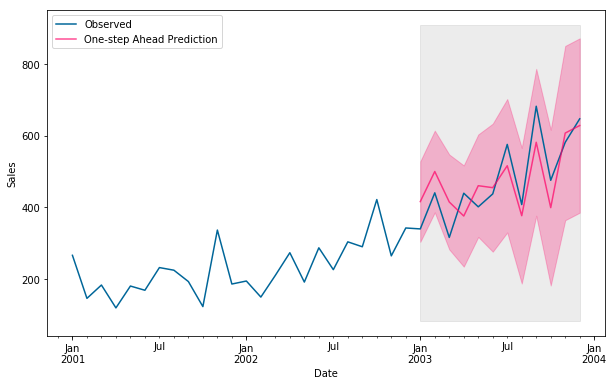

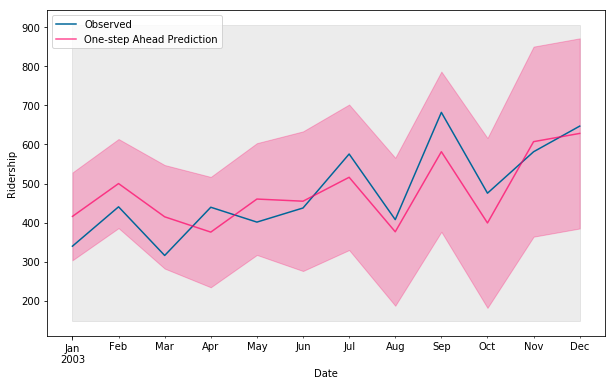

In [100]:
# define SARIMAX model and fit it to the data:
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(4, 0, 2),
                                seasonal_order=(4, 0, 1, 3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
res = mdl.fit()


# fit model to data
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2003-01-01'), 
                          end=pd.to_datetime('2003-12-01'),
                          dynamic=False)
pred_ci = pred.conf_int()
 
# plot in-sample-prediction
plt.figure(figsize=(10, 6))
ax = y['2001':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
              pred_ci.iloc[:, 0], 
             pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
print('RMSE: ', np.sqrt(mean_squared_error(y['2003-01-01': ].values, pred.predicted_mean.values)))

# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2003-01-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend(loc='upper left')
plt.show()

# plot in-sample-prediction
plt.figure(figsize=(10, 6))
ax = y['2003':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');

# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0], 
               pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2003-01-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Ridership')
plt.legend(loc='upper left')
plt.show()

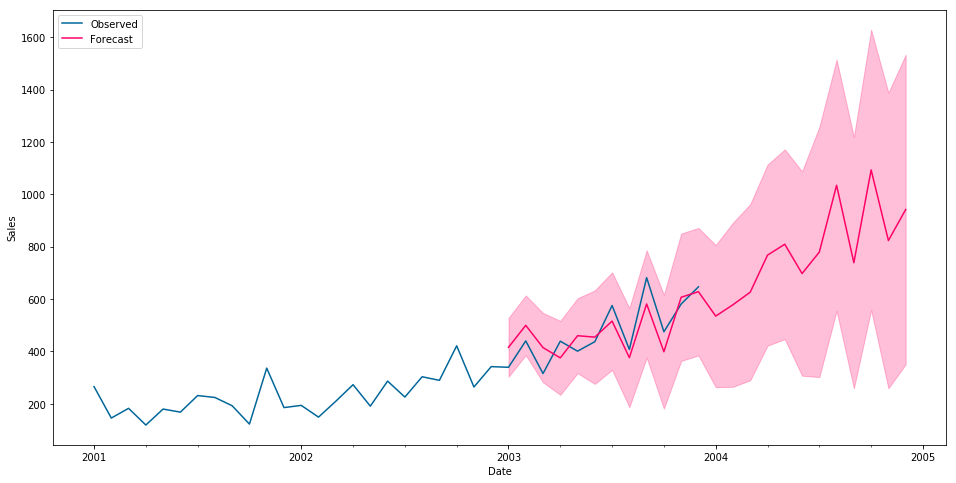

In [101]:
# Forecast (out-of-sample prediction)
mdl = sm.tsa.statespace.SARIMAX(y[:'2002'],
                                order=(4, 0, 2),
                                seasonal_order=(4, 0, 1, 3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
res = mdl.fit()

# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=24, dynamics=False)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 7), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Sales');
plt.legend(loc='upper left')
plt.show()